# biGRU Architecture (Part 3.3)
### This notebook prepares, trains and tests the Bidirectional Gated Recurrent Unit (biGRU) model architecture for sentiment classification

In [ ]:
! pip install datasets
! pip install nltk
! pip install gensim
! pip install huggingface-hub
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download("popular")
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import gensim.downloader as api
import numpy as np
from string import punctuation
from datasets import load_dataset
import string
from nltk.corpus import stopwords
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from nltk.tokenize import word_tokenize
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
import seaborn as sns
import math
import random
from itertools import product
import gc
import copy
import torch.nn.functional as F


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    | 

In [ ]:
from datasets import load_dataset

# Load the Rotten Tomatoes dataset with train, validation, and test splits
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']           # Training set
validation_dataset = dataset['validation'] # Validation set
test_dataset = dataset['test']             # Test set

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.46k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [ ]:
# load a pre-trained Word2Vec model (e.g. "word2vec-google-news-300") from gensim's api
w2vmodel = api.load("fasttext-wiki-news-subwords-300")

[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
# remove punctuation and stopwords
import string
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def tokenize_and_remove_punctuation_and_stopwords(text):
    tokens = word_tokenize(text)  # tokenize the text
    tokens_no_punctuation_or_stopwords = [token for token in tokens if token not in string.punctuation and token not in stop_words]  # yemove punctuation
    return tokens_no_punctuation_or_stopwords

new_tokenized_texts = [tokenize_and_remove_punctuation_and_stopwords(text) for text in train_dataset['text']]

In [ ]:
# get all possible subwords of a word
def get_subwords(word):
    return [word[i:i+n] for n in range(1, len(word) + 1) for i in range(len(word) - n + 1)]

# Training and Evaluation Functions with Early Stopping and Visualization

This code includes the following main components:
1. **EarlyStopper**: A class for implementing early stopping, which helps prevent overfitting by stopping training when validation accuracy stops improving.
2. **train_model**: A function for training a model with optional OOV (out-of-vocabulary) handling, early stopping, and tracking training/validation loss and accuracy.
3. **evaluate_model**: A function for evaluating the model on a test set, displaying a confusion matrix, and calculating accuracy, precision, and F1 score.
4. **plot_loss**: A function for plotting training/validation loss and accuracy curves over epochs for visual analysis.

In [ ]:
# Class for early stopping to prevent overfitting when validation accuracy does not improve
class EarlyStopper:
    def __init__(self, patience=5, verbose=True):
        self.patience = patience  # Number of epochs to wait for improvement
        self.counter = 0  # Tracks consecutive epochs with no improvement
        self.best_acc = 0  # Best validation accuracy observed so far
        self.verbose = verbose  # If True, print early stopping messages

    def early_stop(self, val_acc, model):
        if val_acc > self.best_acc:
            self.best_acc = val_acc  # Update best accuracy
            self.counter = 0  # Reset counter if validation accuracy improves
        else:
            self.counter += 1  # Increment counter if no improvement

        if self.counter >= self.patience:
            if self.verbose:
                print("Early stopping...")  # Print message if stopping
            return True
        return False

# Function to train the model with early stopping and optional OOV handling
def train_model(model, epochs, criterion, optimizer, train_loader, validation_loader, handle_oov=False, earlystopper=EarlyStopper(patience=5, verbose=True)):
    train_loss_history = []  # Track training loss per epoch
    train_accuracy_history = []  # Track training accuracy per epoch
    val_loss_history = []  # Track validation loss per epoch
    val_accuracy_history = []  # Track validation accuracy per epoch
    best_model = model.state_dict()  # Store best model based on validation accuracy
    best_val_accuracy = 0.0  # Initialize best validation accuracy

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_loss = 0
        correct = 0
        total = 0

        # Training loop
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch'):
            if isinstance(labels, list):
                labels = torch.tensor(labels)
            if handle_oov:
                labels = labels.to(device)
            else:
                inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Reset gradients
            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predicted labels
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  # Count correct predictions
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters

            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)  # Compute average training loss
        train_accuracy = correct / total  # Compute training accuracy
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)

        # Validation loop
        model.eval()  # Set model to evaluation mode
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in validation_loader:
                if isinstance(labels, list):
                    labels = torch.tensor(labels)
                if handle_oov:
                    labels = labels.to(device)
                else:
                    inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                total_loss += loss.item()

        val_loss = total_loss / len(validation_loader)  # Compute average validation loss
        val_accuracy = correct / total  # Compute validation accuracy
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")
        print("-" * 60)

        # Early stopping based on validation accuracy
        if earlystopper.early_stop(val_accuracy, model):
            break

        # Save the best model
        if val_accuracy >= best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = copy.deepcopy(model)

    model = copy.deepcopy(best_model)  # Restore best model

    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history, model

# Function to evaluate the model on the test set with optional OOV handling
def evaluate_model(model, test_loader, handle_oov=False):
    model.eval()  # Set model to evaluation mode
    correct, total = 0, 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            if isinstance(labels, list):
                labels = torch.tensor(labels)
            if handle_oov:
                labels = labels.to(device)
            else:
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = correct / total  # Overall accuracy
    print(f'Test Accuracy: {accuracy:.2f}')

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate and print additional metrics
    TN, FP, FN, TP = cm.ravel()
    precision = precision_score(all_labels, all_predictions, average='binary')
    f1 = f1_score(all_labels, all_predictions, average='binary')

    print(f'True Positives (TP): {TP}')
    print(f'True Negatives (TN): {TN}')
    print(f'False Positives (FP): {FP}')
    print(f'False Negatives (FN): {FN}')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'F1 Score: {f1:.2f}')

    return accuracy

# Function to plot training and validation loss and accuracy over epochs
def plot_loss(train_loss, train_accuracy, val_loss, val_accuracy_history, title='Training Curves'):
    epochs = np.arange(1, len(train_loss) + 1)  # List of epoch numbers

    plt.figure(figsize=(12, 6))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss', color='blue', linewidth=2)
    plt.plot(epochs, val_loss, label='Validation Loss', color='orange', linewidth=2)
    plt.title(f"{title} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xticks(ticks=np.arange(1, len(train_loss) + 1, step=max(1, len(epochs) // 10)))
    plt.legend()
    plt.grid(True)

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='Training Accuracy', color='blue', linewidth=2)
    plt.plot(epochs, val_accuracy_history, label='Validation Accuracy', color='orange', linewidth=2)
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.xticks(ticks=np.arange(1, len(train_loss) + 1, step=max(1, len(epochs) // 10)))
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
import gc
import copy
import torch.optim as optim
import torch.nn as nn

def train_with_fixed_params(model_type, hidden_size, learning_rate, batch_size, num_epochs, dropout, num_layers, train_embeddings_bool=False, handle_oov=False):
    # Define input dimensions and output classes for the model
    input_dim = 300  # Embedding dimension
    output_size = 2  # Binary classification output size


    print(f"Running with fixed parameters: hidden_size={hidden_size}, lr={learning_rate}, "
          f"batch_size={batch_size}, epochs={num_epochs}, dropout={dropout}, num_layers={num_layers}")

    # Clear CUDA cache if GPU is available to free memory
    if torch.cuda.device_count() >= 1:
        gc.collect()
        torch.cuda.empty_cache()

    # Model selection based on the specified model_type
    if model_type == "BiLSTM":
        # Initialize BiLSTM model with specified parameters
        model = BiLSTM(
            embeddings=w2vmodel.vectors, input_dim=input_dim, hidden_size=hidden_size,
            output_size=output_size, num_layers=num_layers, dropout=dropout,
            train_embeddings=train_embeddings_bool
        )
    elif model_type == "BiGRU":
        # Initialize BiGRU model with specified parameters
        model = BiGRU(
            input_dim=input_dim, hidden_size=hidden_size, output_size=output_size,
            num_layers=num_layers, dropout=dropout, word2vec_model=w2vmodel,
            train_embeddings=train_embeddings_bool
        )
    elif model_type == "RNNNonOOV":
        # Initialize simple RNN model without OOV handling
        model = RNNNonOOV(
            input_dim, hidden_size, output_size, w2vmodel.vectors,
            train_embeddings=train_embeddings_bool
        )
    elif model_type == "RNNOOV":
        # Initialize simple RNN model with OOV handling
        model = RNNOOV(
            input_dim, hidden_size, output_size, w2vmodel.vectors,
            train_embeddings=train_embeddings_bool
        )
    else:
        # Raise error if model_type is not recognized
        raise ValueError(f"Model '{model_type}' not found. Choose from: BiLSTM, BiGRU, RNNNonOOV, RNNOOV")

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    model.to(device)  # Move model to GPU if available
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model and record training/validation history
    train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history, best_model = train_model(
        model, num_epochs, criterion, optimizer, train_loader, validation_loader, handle_oov=handle_oov
    )

    # Capture best metrics from validation history
    best_val_accuracy = max(val_accuracy_history)
    best_train_accuracy = max(train_accuracy_history)
    best_val_loss = min(val_loss_history)

    # Collect all relevant training metrics in a dictionary
    results = {
        'train_loss_history': train_loss_history,
        'train_accuracy_history': train_accuracy_history,
        'val_loss_history': val_loss_history,
        'val_accuracy_history': val_accuracy_history,
        'best_val_accuracy': best_val_accuracy,
        'best_train_accuracy': best_train_accuracy,
        'best_val_loss': best_val_loss,
    }

    # Return the model with the best validation performance and training results
    return best_model, results


In [ ]:
from torch.utils.data import DataLoader, Dataset
import torch

# Custom Dataset class to handle texts and labels
class SentimentDatasetWithText(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts  # List of preprocessed texts
        self.labels = labels  # Corresponding labels for each text

    def __len__(self):
        return len(self.labels)  # Returns the number of samples in the dataset

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]  # Returns a text-label pair

# Function to create data loaders with OOV handling
def create_data_loaders_with_oov_handling(dataset, batch_size):
    # Preprocess and tokenize texts for train, validation, and test sets
    train_texts = [tokenize_and_remove_punctuation_and_stopwords(text) for text in dataset['train']['text']]
    validation_texts = [tokenize_and_remove_punctuation_and_stopwords(text) for text in dataset['validation']['text']]
    test_texts = [tokenize_and_remove_punctuation_and_stopwords(text) for text in dataset['test']['text']]

    # Create Dataset objects for each split
    train_dataset = SentimentDatasetWithText(train_texts, dataset['train']['label'])
    validation_dataset = SentimentDatasetWithText(validation_texts, dataset['validation']['label'])
    test_dataset = SentimentDatasetWithText(test_texts, dataset['test']['label'])

    # Initialize DataLoaders with a custom collate function for batching
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

    return train_loader, validation_loader, test_loader  # Return DataLoaders for each dataset split

# Custom collate function to handle batching of texts and labels
def collate_fn(batch):
    texts, labels = zip(*batch)  # Separate texts and labels
    return list(texts), torch.tensor(labels)  # Return texts as list and labels as tensor


In [ ]:
# Initialize data loaders for training, validation, and testing sets with a batch size of 64
train_loader, validation_loader, test_loader = create_data_loaders_with_oov_handling(dataset, 64)

# BiGRU Model for Sentence Representation and Sentiment Classification

## Model Architecture
The BiGRU model architecture leverages a bidirectional GRU (Gated Recurrent Unit) layer to capture both forward and backward dependencies in the input text. It consists of the following components:
1. **Embedding Layer**: The embedding layer initializes with pre-trained Word2Vec embeddings, controlled by a `train_embeddings` boolean parameter. If `train_embeddings` is set to `True`, the embeddings are fine-tuned during training; otherwise, they are frozen.
2. **Bidirectional GRU Layer**: A bidirectional GRU is used with a specified hidden size and number of layers, set by `hidden_size` and `num_layers`. The GRU processes the embeddings sequentially in both directions to capture contextual dependencies within the sentence. A dropout layer is applied to the GRU to prevent overfitting.
3. **Fully Connected Layer**: After the GRU layer, a fully connected (FC) layer reduces the dimensionality to match the `output_size`, representing the number of output classes (binary for sentiment classification). This layer provides the final prediction.
---
## Operational Mechanism: Sentence Representation and Sentiment Classification
1. **Embedding Process**: For each word in a sentence, the model either retrieves its embedding directly or, in cases where the word is out-of-vocabulary (OOV), generates an embedding by averaging the embeddings of known subwords. This approach allows the model to handle unknown words gracefully by using subword information.
2. **GRU Encoding**: The sequence of embeddings for each sentence is passed through the bidirectional GRU. The GRU processes each word, considering both past (forward) and future (backward) context, resulting in a comprehensive representation of the entire sentence.
3. **Sentence Representation**: The final hidden states from both directions of the GRU are concatenated to form a fixed-size vector representing the sentence. This concatenation combines the forward and backward context into a single representation that encodes the overall sentiment and meaning.
4. **Classification**: The final sentence representation is passed through a dropout layer for regularization and then fed into a fully connected layer. This layer outputs a prediction for the sentiment classification task.
---
## Design Rationale
- **Embedding Flexibility**: The use of pre-trained Word2Vec embeddings provides a strong foundation for word representations. By setting `train_embeddings` to `True` or `False`, the model allows flexibility in either fine-tuning embeddings for task-specific nuances or freezing them to maintain general semantic properties.
- **Bidirectional GRU**: The bidirectional setup is chosen to capture both past and future contexts, which is crucial for understanding the sentiment of a sentence where meaning can depend on both preceding and following words.
- **Subword Handling for OOV Words**: By breaking down OOV words into known subwords and averaging their embeddings, the model reduces the impact of unknown words on performance, allowing it to generalize better across diverse vocabulary.
- **Dimensionality Reduction via Fully Connected Layer**: The final fully connected layer simplifies the concatenated hidden states into a single output that aligns with the sentiment classification task, making the model efficient and effective for binary sentiment predictions.
  
This architecture effectively combines pre-trained embeddings, bidirectional GRUs, and robust handling of OOV words, resulting in a model capable of nuanced sentence representation and reliable sentiment classification.


In [ ]:
import torch
import torch.nn as nn

class BiGRU(nn.Module):
    def __init__(self, input_dim, hidden_size, output_size, train_embeddings=False, num_layers=2, dropout=0.3, word2vec_model=w2vmodel):
        super(BiGRU, self).__init__()

        # Initialize embeddings using pre-trained Word2Vec vectors with an option to freeze or train
        self.embeddings = nn.Embedding.from_pretrained(
            torch.tensor(word2vec_model.vectors, dtype=torch.float32),
            freeze=not train_embeddings,  # Controlled by the train_embeddings parameter
            sparse=False
        )
        self.embedding_dim = word2vec_model.vectors.shape[1]  # Set embedding dimension

        # Define a bidirectional GRU layer with specified hidden size, number of layers, and dropout
        self.bigru = nn.GRU(
            input_dim, hidden_size, num_layers=num_layers, batch_first=True,
            bidirectional=True, dropout=dropout
        )

        # Fully connected layer for final classification output
        self.fc = nn.Linear(hidden_size * 2, output_size)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

        # Dictionary for word-to-index mapping for handling vocabulary
        self.word_to_index = word2vec_model.key_to_index

    def encode_with_subwords(self, word, device):
        # Handle out-of-vocabulary words by averaging embeddings of subwords
        subwords = get_subwords(word)
        subword_indices = [
            self.word_to_index[subword]
            for subword in subwords if subword in self.word_to_index
        ]

        # Return the average embedding for subwords if available, otherwise a zero vector
        if subword_indices:
            subword_tensor = torch.tensor(subword_indices, device=device)
            subword_embeddings = self.embeddings(subword_tensor)
            return subword_embeddings.mean(dim=0)
        else:
            return torch.zeros(self.embedding_dim, device=device)

    def forward(self, x):
        device = next(self.parameters()).device
        batch_embeddings = []

        # Encode each word in the sentence; for OOV words, use subword embeddings
        for sentence in x:
            sentence_embeddings = []
            for word in sentence:
                if word is not None and word in self.word_to_index:
                    word_idx = torch.tensor(self.word_to_index[word], device=device)
                    word_embedding = self.embeddings(word_idx)
                else:
                    word_embedding = self.encode_with_subwords(word, device)
                sentence_embeddings.append(word_embedding)

            sentence_embeddings = torch.stack(sentence_embeddings)
            batch_embeddings.append(sentence_embeddings)

        # Pad sequences to handle sentences of different lengths
        batch_embeddings = torch.nn.utils.rnn.pad_sequence(batch_embeddings, batch_first=True)

        # Pass embeddings through bidirectional GRU
        output, hidden = self.bigru(batch_embeddings)

        # Concatenate the final hidden states from both directions of the GRU
        final_output = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)

        # Apply dropout to final output
        final_output = self.dropout(final_output)

        # Pass through fully connected layer for final classification
        return self.fc(final_output)


Running with fixed parameters: hidden_size=128, lr=0.001, batch_size=128, epochs=100, dropout=0.5, num_layers=1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
Epoch 1/100: 100%|██████████| 134/134 [05:33<00:00,  2.49s/batch]


Epoch 1/100 | Train Loss: 0.5665 | Train Accuracy: 0.6918 | Val Loss: 0.4963 | Val Accuracy: 0.7617
------------------------------------------------------------


Epoch 2/100: 100%|██████████| 134/134 [05:31<00:00,  2.48s/batch]


Epoch 2/100 | Train Loss: 0.2705 | Train Accuracy: 0.8906 | Val Loss: 0.5274 | Val Accuracy: 0.7598
------------------------------------------------------------


Epoch 3/100: 100%|██████████| 134/134 [05:32<00:00,  2.48s/batch]


Epoch 3/100 | Train Loss: 0.1035 | Train Accuracy: 0.9628 | Val Loss: 0.7947 | Val Accuracy: 0.7458
------------------------------------------------------------


Epoch 4/100: 100%|██████████| 134/134 [05:32<00:00,  2.48s/batch]


Epoch 4/100 | Train Loss: 0.0515 | Train Accuracy: 0.9834 | Val Loss: 0.8900 | Val Accuracy: 0.7458
------------------------------------------------------------


Epoch 5/100: 100%|██████████| 134/134 [05:32<00:00,  2.48s/batch]


Epoch 5/100 | Train Loss: 0.0286 | Train Accuracy: 0.9911 | Val Loss: 1.1964 | Val Accuracy: 0.7373
------------------------------------------------------------


Epoch 6/100: 100%|██████████| 134/134 [05:31<00:00,  2.48s/batch]


Epoch 6/100 | Train Loss: 0.0147 | Train Accuracy: 0.9961 | Val Loss: 1.5067 | Val Accuracy: 0.7383
------------------------------------------------------------
Early stopping...
Fixed Parameters: {'model_type': 'BiGRU', 'hidden_size': 128, 'learning_rate': 0.001, 'batch_size': 128, 'num_epochs': 100, 'dropout': 0.5, 'num_layers': 1, 'train_embeddings_bool': True, 'handle_oov': True}
Best Validation Loss: 0.4963
Best Validation Accuracy: 0.7617
Best Training Accuracy: 0.9961


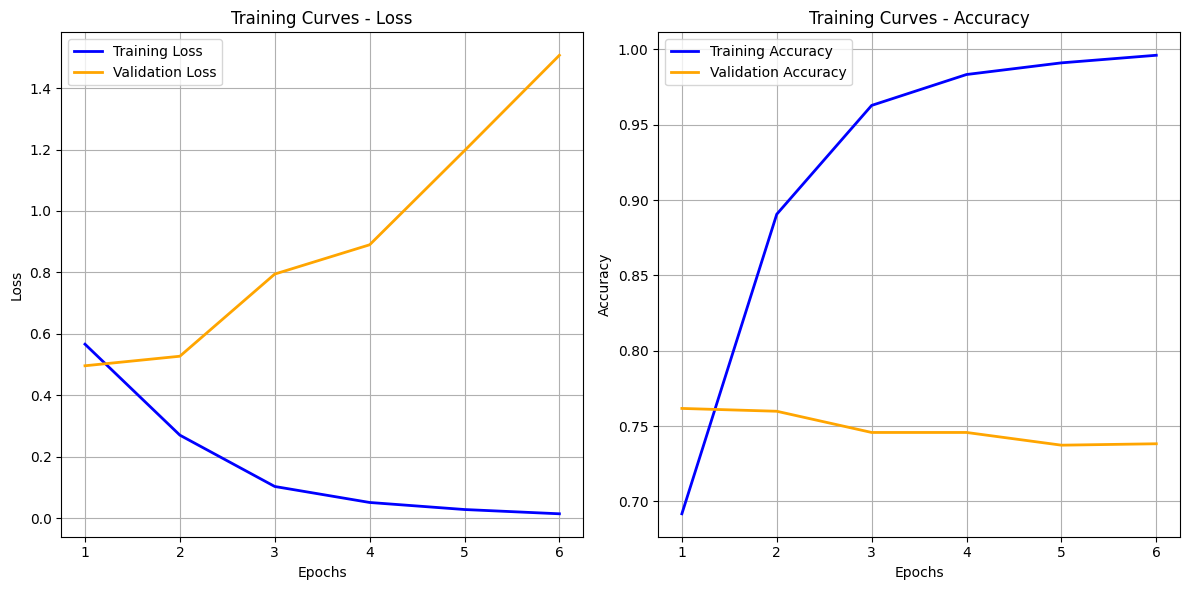

In [ ]:
import gc
import torch
import torch.optim as optim
from tqdm import tqdm

# Set up device for training (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define fixed hyperparameters for training the BiGRU model
fixed_params = {
    'model_type': 'BiGRU',          # Model architecture to use
    'hidden_size': 128,             # Hidden size for GRU layers
    'learning_rate': 0.001,         # Learning rate for optimizer
    'batch_size': 128,              # Batch size for training
    'num_epochs': 100,              # Number of training epochs
    'dropout': 0.5,                 # Dropout rate for regularization
    'num_layers': 1,                # Number of GRU layers
    'train_embeddings_bool': True,  # Whether to fine-tune embeddings
    'handle_oov': True              # Option to handle out-of-vocabulary words
}

# Train the model with specified parameters and store the best model and results
best_model, results = train_with_fixed_params(**fixed_params)

# Print fixed parameters and best validation and training results
print(f"Fixed Parameters: {fixed_params}")
print(f"Best Validation Loss: {results['best_val_loss']:.4f}")
print(f"Best Validation Accuracy: {results['best_val_accuracy']:.4f}")
print(f"Best Training Accuracy: {results['best_train_accuracy']:.4f}")

# Plot training and validation loss and accuracy over epochs
plot_loss(
    results['train_loss_history'],
    results['train_accuracy_history'],
    results['val_loss_history'],
    results['val_accuracy_history']
)



### Training Results Analysis (Displayed Above)

#### Key Observations:
- **Training vs. Validation**:
  - The model achieved a nearly perfect training accuracy (99.6%) with very low training loss, while validation accuracy peaked early at 76.17% and then stagnated.
  - The increase in validation loss despite decreasing training loss indicates overfitting.

#### Justification for Overfitting:
- **Hyperparameter Tuning**:
  - Extensive hyperparameter tuning was conducted, testing various architectures and regularization settings. Attempts to reduce model complexity or increase dropout lowered validation accuracy, making the model less effective.
  - The current parameters (`hidden_size=128`, `num_layers=1`, `dropout=0.5`) provided the best trade-off, achieving the highest validation accuracy while controlling overfitting as much as possible.

#### Rationale for Using a Single Layer
- **Minimizing Overfitting**:
  - Stacking multiple GRU layers (e.g., `num_layers=2` or more) was tested but resulted in increased overfitting. The added complexity led to much higher training accuracy but a significant drop in validation performance.
  - The single-layer configuration kept the model simpler, which allowed for better generalization on the validation set without sacrificing much performance.

#### Conclusion:
Although overfitting is present, this configuration yielded the best validation performance among tested setups. The choice to use a single GRU layer was essential in achieving a balance between model complexity and generalization capability.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:1392: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.gru(


Test Accuracy: 0.78


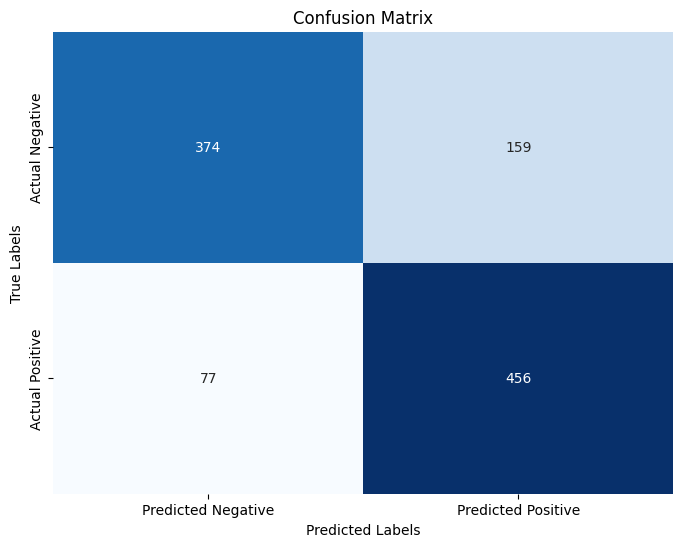

True Positives (TP): 456
True Negatives (TN): 374
False Positives (FP): 159
False Negatives (FN): 77
Accuracy: 0.78
Precision: 0.74
F1 Score: 0.79


0.7786116322701688

In [ ]:
# Evaluate the best model on the test set with OOV (out-of-vocabulary) handling enabled
evaluate_model(best_model,test_loader,True)

### Test Results Analysis (Displayed Above)

#### Summary of Performance Metrics
- **Accuracy**: 0.78
- **Precision**: 0.74
- **F1 Score**: 0.79

#### Confusion Matrix Breakdown
- **True Positives (TP)**: 456 — Correctly classified as positive.
- **True Negatives (TN)**: 374 — Correctly classified as negative.
- **False Positives (FP)**: 159 — Negative samples misclassified as positive.
- **False Negatives (FN)**: 77 — Positive samples misclassified as negative.

#### Observations
- **False Positives**: With 159 false positives, the model tends to misclassify some negative samples as positive. This suggests that certain expressions in negative samples may resemble those in positive samples, leading to misclassification.
- **False Negatives**: Fewer false negatives (77) indicate the model is somewhat better at correctly identifying positive samples.

#### Performance Implications
- **Balanced Precision and Recall**: With a precision of 0.74 and an F1 score of 0.79, the model shows a reasonable balance between precision and recall. This balance is important in applications where both types of errors (false positives and false negatives) have implications.
- **Overall Accuracy**: An accuracy of 78% indicates that the model performs reasonably well in sentiment classification but has room for further fine-tuning.

#### Potential Areas for Improvement
1. **Reducing False Positives**: Fine-tuning to better distinguish expressions in negative samples could help decrease the false positive rate.
2. **Threshold Adjustment**: Adjusting the classification threshold might help improve the precision-recall balance, depending on specific application needs.

Overall, this model provides a solid baseline, and targeted improvements could further enhance its ability to handle subtle distinctions in sentiment classification.
